# 09 — Undervalued Players & Dream Team

**Goal:** Apply the trained models to all players and surface recruitment opportunities.

**Inputs:** `../models/advanced_models.pkl` · `../data/processed/featured_{pos}.csv` · `preprocessors.pkl` · `final_features.json`

**Outputs:** `../data/processed/all_predictions.csv` · `../data/processed/dream_team.csv` · `../figures/09_*.png`

**Next:** `10_final_report_and_visualizations.ipynb`

---
**Logic:**
- Apply the same preprocessing pipeline (target encoding + StandardScaler) to **all** players using training-time statistics from `preprocessors.pkl` — no data leakage
- For players **with** a valuation: `undervaluation_ratio = predicted_€ / actual_€` — ratio > 1 means model values them higher than market
- For players **without** a valuation: predicted value only (hidden gems, scouting targets)
- **Dream team (4-3-3):** 1 GK + 4 DEF + 3 MID + 3 ATT, selected by highest `undervaluation_ratio` with ≥ 10 appearances

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

PROC_PATH    = '../data/processed/'
MODELS_PATH  = '../models/'
FIGURES_PATH = '../figures/'
os.makedirs(FIGURES_PATH, exist_ok=True)

POSITIONS = ['GK', 'DEF', 'MID', 'ATT']

# Dream team slots per position (4-3-3)
DREAM_SLOTS = {'GK': 1, 'DEF': 4, 'MID': 3, 'ATT': 3}

# Minimum appearances for dream team eligibility
MIN_APPEARANCES = 10

print('Imports OK')

Imports OK


## 1. Load Models & Preprocessors

In [2]:
with open(MODELS_PATH + 'advanced_models.pkl', 'rb') as f:
    models = pickle.load(f)

with open(PROC_PATH + 'preprocessors.pkl', 'rb') as f:
    preprocessors = pickle.load(f)

with open(PROC_PATH + 'final_features.json') as f:
    FINAL_FEATURES = json.load(f)

scalers          = preprocessors['scalers']
league_encodings = preprocessors['league_encodings']

# Load ALL featured players (not just labeled)
featured = {}
for pos in POSITIONS:
    featured[pos] = pd.read_csv(PROC_PATH + f'featured_{pos.lower()}.csv')
    n_total = len(featured[pos])
    n_val   = featured[pos]['market_value_in_eur'].notna().sum()
    print(f'  {pos}: {n_total:,} players  ({n_val:,} with valuation, {n_total-n_val:,} without)')

  GK: 3,745 players  (3,313 with valuation, 432 without)
  DEF: 10,714 players  (9,867 with valuation, 847 without)
  MID: 9,766 players  (8,976 with valuation, 790 without)
  ATT: 9,299 players  (8,554 with valuation, 745 without)


## 2. Preprocess All Players

Replicate the notebook 05 pipeline using **training-time** statistics only:
1. Target-encode `current_club_domestic_competition_id` with saved league map
2. Select `FINAL_FEATURES[pos]`
3. Scale with the saved `StandardScaler`

In [3]:
CAT_COL = 'current_club_domestic_competition_id'
ENC_COL = 'league_mean_value'

X_all = {}

for pos in POSITIONS:
    df     = featured[pos].copy()
    enc    = league_encodings[pos]
    scaler = scalers[pos]
    feats  = FINAL_FEATURES[pos]

    # 1. Target-encode league (unseen leagues → global train mean)
    df[ENC_COL] = df[CAT_COL].map(enc['map']).fillna(enc['global_mean'])

    # 2. Select & fill remaining NaN with 0
    X = df[feats].fillna(0)

    # 3. Scale — transform only, no fit
    X_all[pos] = pd.DataFrame(scaler.transform(X), columns=feats, index=df.index)

    print(f'  {pos}: {X_all[pos].shape[0]:,} × {X_all[pos].shape[1]} preprocessed')

  GK: 3,745 × 18 preprocessed
  DEF: 10,714 × 19 preprocessed
  MID: 9,766 × 18 preprocessed
  ATT: 9,299 × 19 preprocessed


## 3. Generate Predictions for All Players

In [4]:
predictions = {}

for pos in POSITIONS:
    df       = featured[pos].copy()
    pred_log = models[pos].predict(X_all[pos])
    pred_eur = np.expm1(pred_log)

    df['pred_log']   = pred_log
    df['pred_eur']   = pred_eur
    df['pred_eur_M'] = pred_eur / 1e6

    # Undervaluation metrics — only for players with actual valuations
    has_val = df['market_value_in_eur'].notna()
    df.loc[has_val, 'underval_ratio'] = (
        df.loc[has_val, 'pred_eur'] / df.loc[has_val, 'market_value_in_eur']
    )
    df.loc[has_val, 'value_gap_M'] = (
        (df.loc[has_val, 'pred_eur'] - df.loc[has_val, 'market_value_in_eur']) / 1e6
    )

    predictions[pos] = df
    n_buy = (df.loc[has_val, 'underval_ratio'] > 1.5).sum()
    print(f'  {pos}: {n_buy:,} players with underval_ratio > 1.5 (predicted ≥ 50% above market)')

  GK: 669 players with underval_ratio > 1.5 (predicted ≥ 50% above market)
  DEF: 1,864 players with underval_ratio > 1.5 (predicted ≥ 50% above market)
  MID: 1,721 players with underval_ratio > 1.5 (predicted ≥ 50% above market)
  ATT: 1,786 players with underval_ratio > 1.5 (predicted ≥ 50% above market)


## 4. Top Undervalued Players per Position

Ranked by `undervaluation_ratio`. Must have a valuation + ≥ 10 appearances.

In [5]:
TOP_N   = 15
DISPLAY = ['name', 'age', 'market_value_m', 'pred_eur_M', 'underval_ratio',
           'value_gap_M', 'total_appearances', 'current_club_domestic_competition_id']

top_undervalued = {}

for pos in POSITIONS:
    df = predictions[pos]
    mask = (
        df['market_value_in_eur'].notna() &
        (df['total_appearances'] >= MIN_APPEARANCES) &
        (df['underval_ratio'] > 1.0)
    )
    top = df[mask].nlargest(TOP_N, 'underval_ratio')[DISPLAY].copy()
    top[['market_value_m','pred_eur_M','underval_ratio','value_gap_M']] = \
        top[['market_value_m','pred_eur_M','underval_ratio','value_gap_M']].round(2)
    top_undervalued[pos] = top

    print(f'\n{pos} — Top {TOP_N} most undervalued:')
    print(top.to_string(index=False))


GK — Top 15 most undervalued:
                name  age  market_value_m  pred_eur_M  underval_ratio  value_gap_M  total_appearances current_club_domestic_competition_id
      Igor Levchenko   34            0.01        0.15           14.86         0.14              15.00                                 UKR1
      Ivan Pelizzoli   45            0.02        0.27           10.67         0.24              14.00                                  IT1
      Utku Yuvakuran   28            0.05        0.50           10.06         0.45              11.00                                  TR1
   Pierluigi Gollini   30            0.80        7.90            9.87         7.10             164.00                                  IT1
        Dusan Pernis   41            0.01        0.09            9.50         0.08              18.00                                  GR1
     Nereo Champagne   40            0.01        0.09            9.50         0.08              14.00                                  

## 5. Top Overvalued Players per Position

Model values them significantly below market — candidates to sell or avoid buying.

In [6]:
for pos in POSITIONS:
    df = predictions[pos]
    mask = (
        df['market_value_in_eur'].notna() &
        (df['total_appearances'] >= MIN_APPEARANCES) &
        (df['underval_ratio'] < 1.0)
    )
    top = df[mask].nsmallest(10, 'underval_ratio')[DISPLAY].copy()
    top[['market_value_m','pred_eur_M','underval_ratio','value_gap_M']] = \
        top[['market_value_m','pred_eur_M','underval_ratio','value_gap_M']].round(2)

    print(f'\n{pos} — Top 10 most overvalued:')
    print(top.to_string(index=False))


GK — Top 10 most overvalued:
                 name  age  market_value_m  pred_eur_M  underval_ratio  value_gap_M  total_appearances current_club_domestic_competition_id
         Márton Fülöp   42            1.25        0.17            0.14        -1.08               26.0                                  GR1
        Ibrahim Sehic   37            1.20        0.17            0.14        -1.03              145.0                                  TR1
         Milan Borjan   38            1.00        0.15            0.15        -0.85               33.0                                  TR1
        Víctor Valdés   43            2.00        0.31            0.15        -1.69              113.0                                  GB1
Vladimir Disljenkovic   44            1.00        0.16            0.16        -0.84               33.0                                 UKR1
      Fabien Farnolle   40            0.35        0.06            0.17        -0.29               78.0                            

## 6. Hidden Gems — Players Without a Valuation

No Transfermarkt record exists for these players. The model's prediction is the only signal
of their potential worth — useful for scouting lower leagues and uncontracted players.

In [7]:
GEM_COLS = ['name', 'age', 'pred_eur_M', 'total_appearances',
            'current_club_domestic_competition_id']

for pos in POSITIONS:
    df = predictions[pos]
    mask = (
        df['market_value_in_eur'].isna() &
        (df['total_appearances'] >= MIN_APPEARANCES)
    )
    gems = df[mask].nlargest(10, 'pred_eur_M')[GEM_COLS].copy()
    gems['pred_eur_M'] = gems['pred_eur_M'].round(2)

    print(f'\n{pos} — Top 10 unvalued players by predicted worth:')
    print(gems.to_string(index=False))


GK — Top 10 unvalued players by predicted worth:
           name  age  pred_eur_M  total_appearances current_club_domestic_competition_id
    Andy Fisher   27        0.02               13.0                                  SC1
       Bernardo   23        0.02               22.0                                  PO1
   Timon Weiner   26        0.02               18.0                                   L1
Maksym Mekhaniv   29        0.02               16.0                                 UKR1

DEF — Top 10 unvalued players by predicted worth:
            name  age  pred_eur_M  total_appearances current_club_domestic_competition_id
   Max Finkgräfe   21        0.04               30.0                                   L1
    Jordi Altena   22        0.04               11.0                                  SC1
     Pedro Bondo   21        0.03               16.0                                  PO1
Giorgi Tabatadze   20        0.03               11.0                                  DK1
 Luk

## 7. Undervaluation Bubble Chart

**X:** actual value · **Y:** predicted value · **Colour:** undervaluation category.
Points above the diagonal are undervalued; below are overvalued.

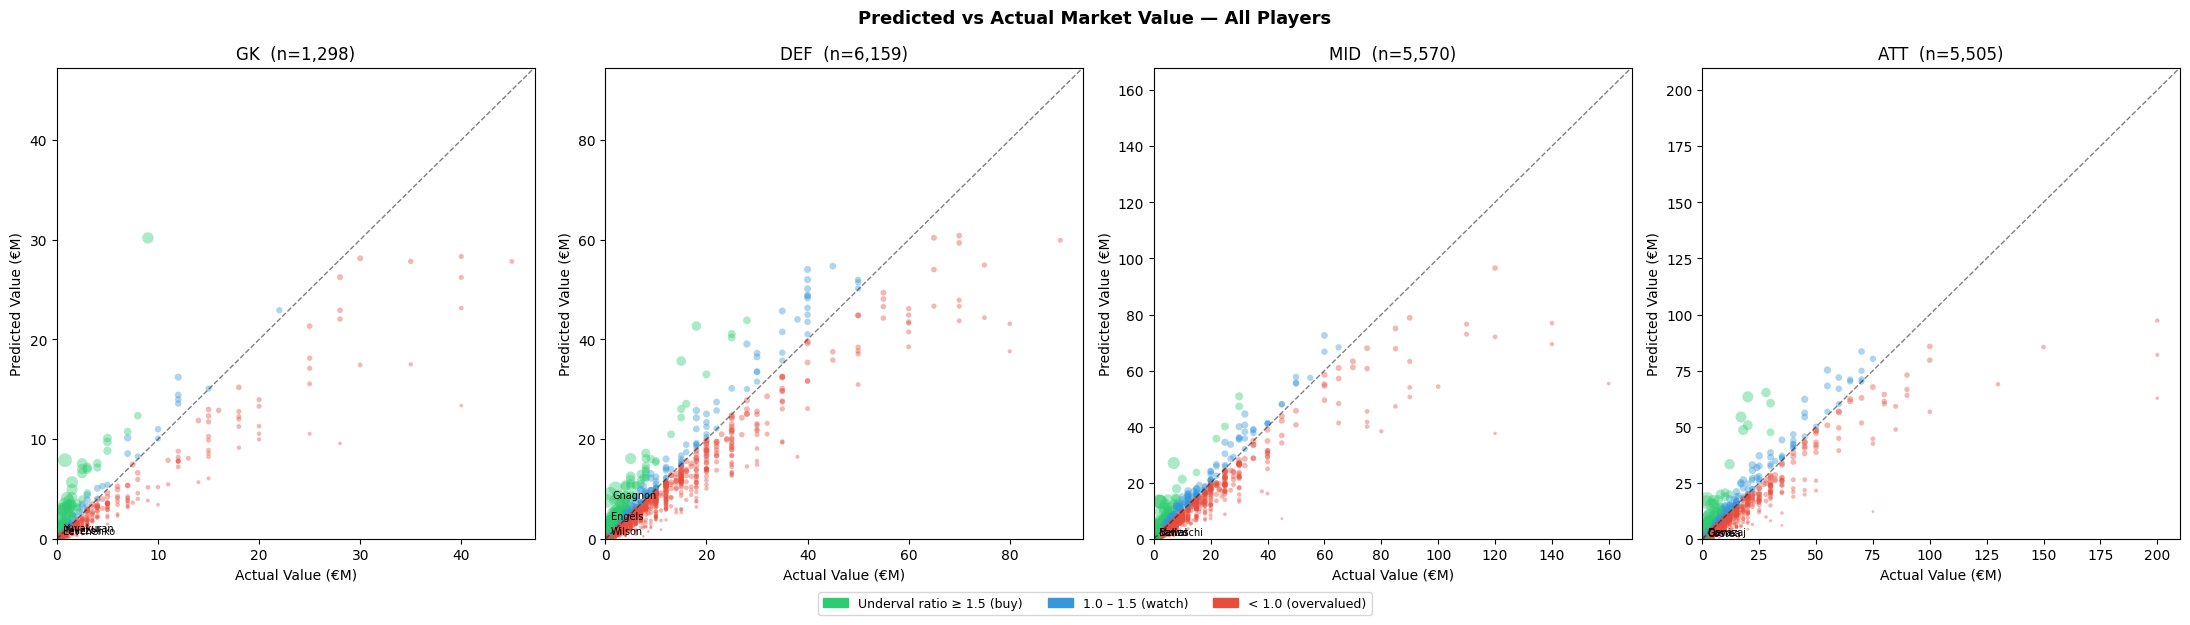

Saved.


In [8]:
fig, axes = plt.subplots(1, 4, figsize=(22, 6))

for ax, pos in zip(axes, POSITIONS):
    df = predictions[pos]
    mask = (
        df['market_value_in_eur'].notna() &
        (df['total_appearances'] >= MIN_APPEARANCES)
    )
    d = df[mask].copy()

    actual_M = d['market_value_in_eur'] / 1e6
    pred_M   = d['pred_eur_M']
    ratio    = d['underval_ratio'].clip(0.2, 5)

    colors = np.where(d['underval_ratio'] >= 1.5, '#2ecc71',
             np.where(d['underval_ratio'] >= 1.0, '#3498db', '#e74c3c'))

    ax.scatter(actual_M, pred_M, s=ratio * 20, c=colors, alpha=0.4, linewidths=0)

    lim = max(actual_M.max(), pred_M.max()) * 1.05
    ax.plot([0, lim], [0, lim], 'k--', linewidth=1, alpha=0.5, label='Fair value')

    # Label top 3 undervalued
    for _, row in d.nlargest(3, 'underval_ratio').iterrows():
        ax.annotate(row['name'].split()[-1],
                    xy=(row['market_value_m'], row['pred_eur_M']),
                    fontsize=7, xytext=(4, 2), textcoords='offset points')

    ax.set_xlabel('Actual Value (€M)')
    ax.set_ylabel('Predicted Value (€M)')
    ax.set_title(f'{pos}  (n={len(d):,})')
    ax.set_xlim(0, lim); ax.set_ylim(0, lim)

handles = [
    mpatches.Patch(color='#2ecc71', label='Underval ratio ≥ 1.5 (buy)'),
    mpatches.Patch(color='#3498db', label='1.0 – 1.5 (watch)'),
    mpatches.Patch(color='#e74c3c', label='< 1.0 (overvalued)'),
]
fig.legend(handles=handles, loc='lower center', ncol=3, fontsize=9,
           bbox_to_anchor=(0.5, -0.04))

plt.suptitle('Predicted vs Actual Market Value — All Players', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '09_undervaluation_bubble.png', bbox_inches='tight')
plt.show()
print('Saved.')

## 8. Dream Team — 4-3-3

Best undervalued XI: highest `undervaluation_ratio` per position slot,
with `total_appearances ≥ 10`.

In [9]:
dream_team_rows = []

for pos in POSITIONS:
    df   = predictions[pos]
    mask = (
        df['market_value_in_eur'].notna() &
        (df['total_appearances'] >= MIN_APPEARANCES)
    )
    picks = df[mask].nlargest(DREAM_SLOTS[pos], 'underval_ratio')

    for _, row in picks.iterrows():
        dream_team_rows.append({
            'position_group': pos,
            'name':           row['name'],
            'age':            int(row['age']),
            'actual_value_M': round(row['market_value_m'], 2),
            'predicted_M':    round(row['pred_eur_M'], 2),
            'underval_ratio': round(row['underval_ratio'], 2),
            'value_gap_M':    round(row['value_gap_M'], 2),
            'appearances':    int(row['total_appearances']),
            'league':         row['current_club_domestic_competition_id'],
        })

dream_team      = pd.DataFrame(dream_team_rows)
total_cost      = dream_team['actual_value_M'].sum()
total_pred      = dream_team['predicted_M'].sum()
total_gap       = dream_team['value_gap_M'].sum()

print('=' * 72)
print('  DREAM TEAM (4-3-3) — Most Undervalued XI')
print('=' * 72)
for pos in POSITIONS:
    print(f'\n  [{pos}]')
    for _, row in dream_team[dream_team['position_group'] == pos].iterrows():
        print(f'    {row["name"]:<28}  age={row["age"]:>2}  '
              f'actual={row["actual_value_M"]:>6.1f}M€  '
              f'model={row["predicted_M"]:>6.1f}M€  '
              f'ratio={row["underval_ratio"]:>5.2f}x  '
              f'({row["league"]})')

print(f'\n  Total squad cost:      {total_cost:>7.1f}M€')
print(f'  Total predicted value: {total_pred:>7.1f}M€')
print(f'  Total value gap:       +{total_gap:>6.1f}M€')
print('=' * 72)

  DREAM TEAM (4-3-3) — Most Undervalued XI

  [GK]
    Igor Levchenko                age=34  actual=   0.0M€  model=   0.1M€  ratio=14.86x  (UKR1)

  [DEF]
    Marc Wilson                   age=38  actual=   0.0M€  model=   0.3M€  ratio=33.85x  (GB1)
    Björn Engels                  age=31  actual=   0.1M€  model=   3.4M€  ratio=33.66x  (BE1)
    Joris Gnagnon                 age=28  actual=   0.3M€  model=   7.7M€  ratio=25.49x  (ES1)
    Constantin Nica               age=32  actual=   0.0M€  model=   0.2M€  ratio=24.55x  (IT1)

  [MID]
    Floriano Vanzo                age=31  actual=   0.0M€  model=   0.3M€  ratio=28.95x  (BE1)
    Raheem Lawal                  age=35  actual=   0.0M€  model=   0.2M€  ratio=22.74x  (TR1)
    Fernando Belluschi            age=42  actual=   0.0M€  model=   0.4M€  ratio=16.76x  (TR1)

  [ATT]
    Enis Gavazaj                  age=30  actual=   0.0M€  model=   0.3M€  ratio=27.66x  (RU1)
    Germán Denis                  age=44  actual=   0.0M€  model= 

## 9. Dream Team — Pitch Visualisation

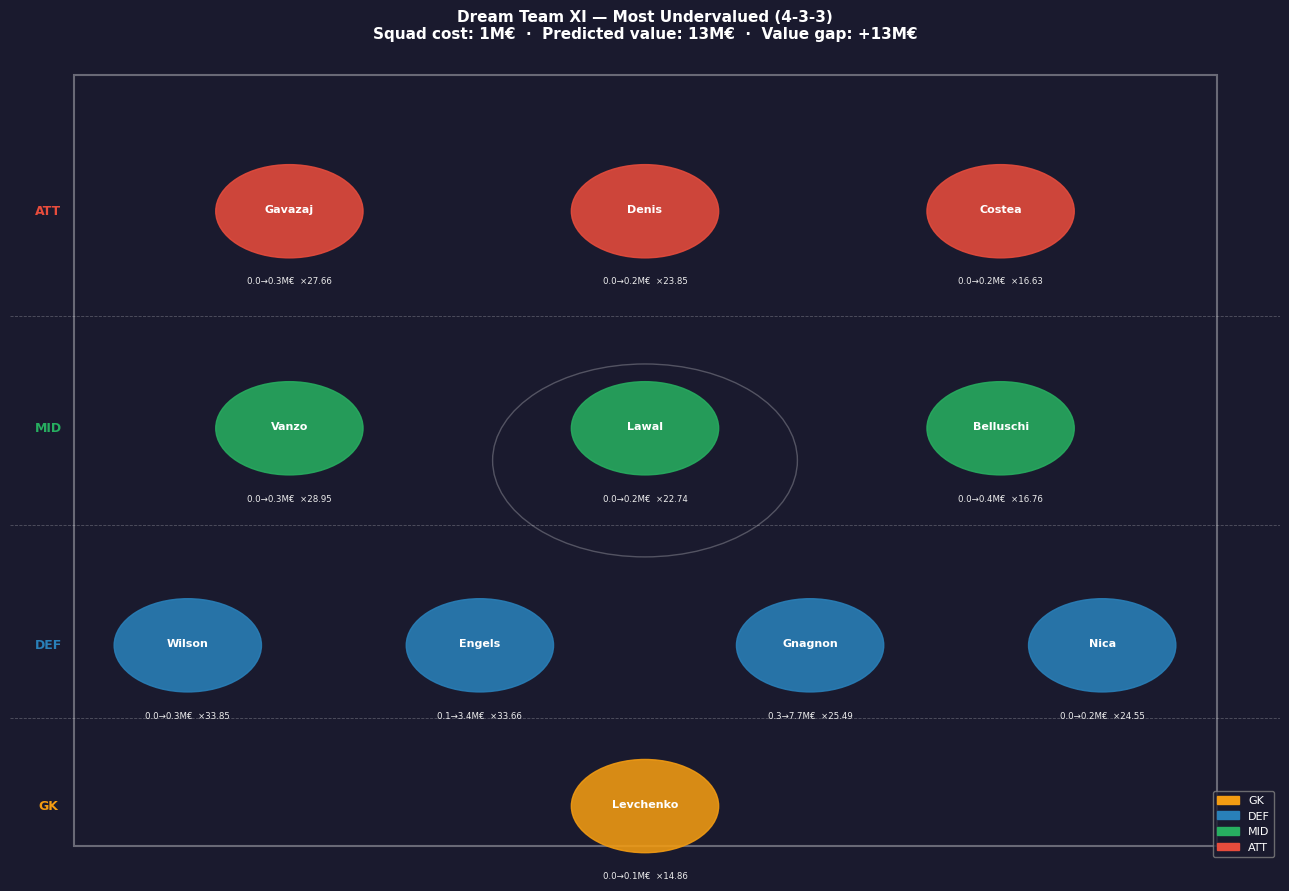

Saved.


In [10]:
fig, ax = plt.subplots(figsize=(13, 9))
ax.set_facecolor('#2d6a2d')
fig.patch.set_facecolor('#1a1a2e')

# Pitch markings
for y in [0.18, 0.42, 0.68]:
    ax.axhline(y, color='white', linewidth=0.6, alpha=0.25, linestyle='--')
ax.add_patch(plt.Rectangle((0.05, 0.02), 0.90, 0.96,
             fill=False, edgecolor='white', linewidth=1.5, alpha=0.35))
ax.add_patch(plt.Circle((0.5, 0.5), 0.12, fill=False,
             edgecolor='white', linewidth=1, alpha=0.25))

layout = {
    'GK':  [(0.50, 0.07)],
    'DEF': [(0.14, 0.27), (0.37, 0.27), (0.63, 0.27), (0.86, 0.27)],
    'MID': [(0.22, 0.54), (0.50, 0.54), (0.78, 0.54)],
    'ATT': [(0.22, 0.81), (0.50, 0.81), (0.78, 0.81)],
}
pos_colors = {'GK': '#f39c12', 'DEF': '#2980b9', 'MID': '#27ae60', 'ATT': '#e74c3c'}

for pos in POSITIONS:
    color   = pos_colors[pos]
    players = dream_team[dream_team['position_group'] == pos]
    for (x, y), (_, row) in zip(layout[pos], players.iterrows()):
        ax.add_patch(plt.Circle((x, y), 0.058, color=color, zorder=3, alpha=0.88))
        short = row['name'].split()[-1]
        ax.text(x, y + 0.002, short,
                ha='center', va='center', fontsize=8, fontweight='bold',
                color='white', zorder=4)
        ax.text(x, y - 0.082,
                f'{row["actual_value_M"]:.1f}→{row["predicted_M"]:.1f}M€  ×{row["underval_ratio"]:.2f}',
                ha='center', va='top', fontsize=6.2, color='#eeeeee', zorder=4)

# Position badges
for pos, (x, y) in [('GK',(0.03,0.07)),('DEF',(0.03,0.27)),
                     ('MID',(0.03,0.54)),('ATT',(0.03,0.81))]:
    ax.text(x, y, pos, ha='center', va='center', fontsize=9,
            fontweight='bold', color=pos_colors[pos])

ax.set_xlim(0, 1); ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title(
    f'Dream Team XI — Most Undervalued (4-3-3)\n'
    f'Squad cost: {total_cost:.0f}M€  ·  '
    f'Predicted value: {total_pred:.0f}M€  ·  '
    f'Value gap: +{total_gap:.0f}M€',
    color='white', fontsize=11, fontweight='bold', pad=14
)
handles = [mpatches.Patch(color=c, label=p) for p, c in pos_colors.items()]
ax.legend(handles=handles, loc='lower right', fontsize=8,
          facecolor='#1a1a2e', labelcolor='white', edgecolor='gray')

plt.tight_layout()
plt.savefig(FIGURES_PATH + '09_dream_team_pitch.png', dpi=150,
            facecolor=fig.get_facecolor(), bbox_inches='tight')
plt.show()
print('Saved.')

## 10. Top 10 Undervalued per Position — Bar Chart

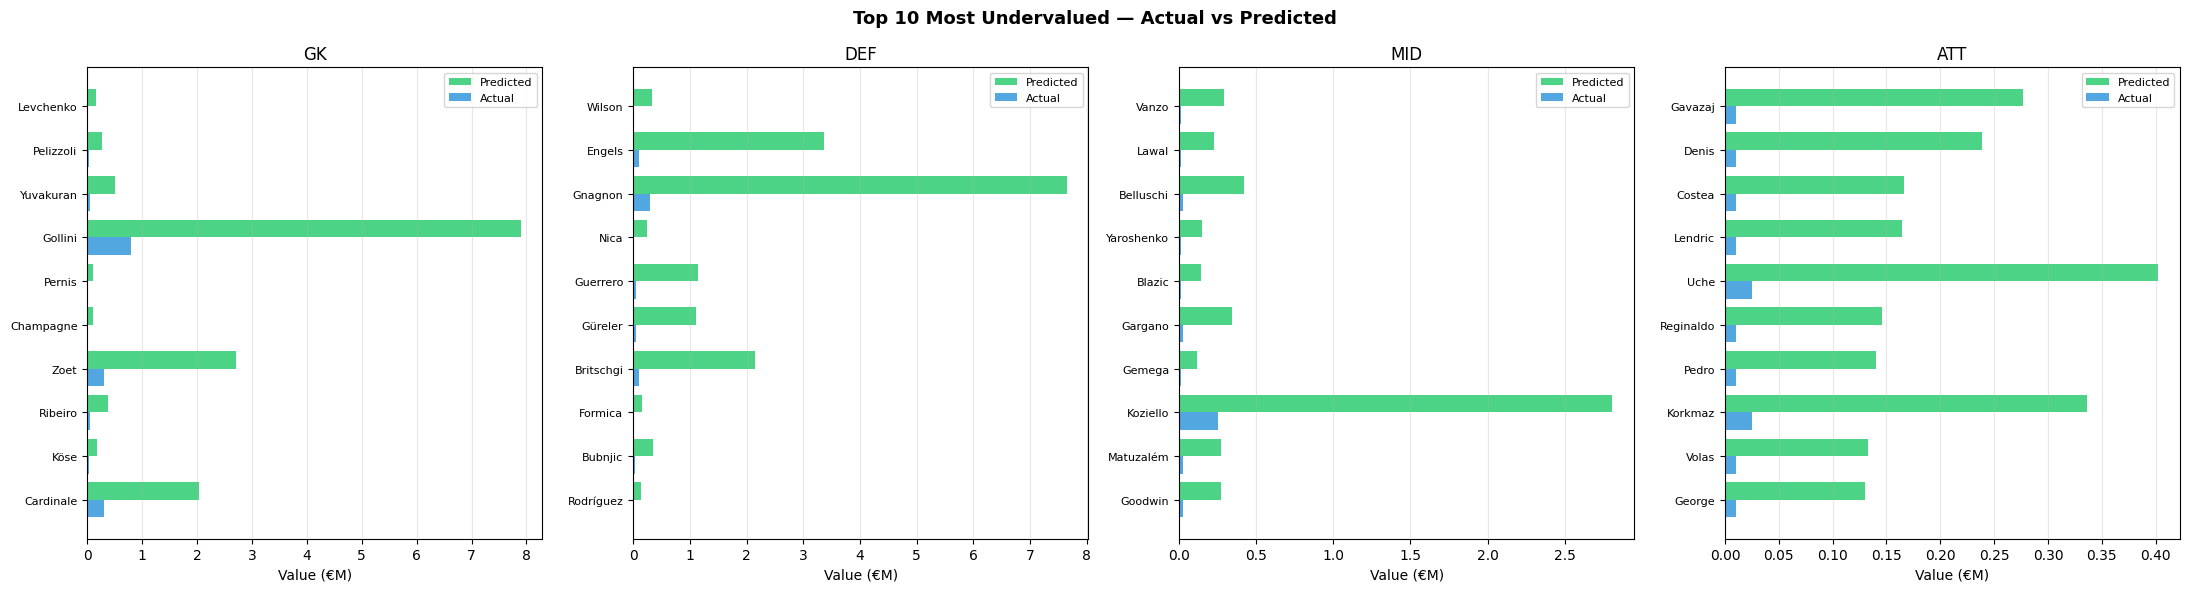

Saved.


In [11]:
fig, axes = plt.subplots(1, 4, figsize=(22, 6))

for ax, pos in zip(axes, POSITIONS):
    df = predictions[pos]
    mask = (
        df['market_value_in_eur'].notna() &
        (df['total_appearances'] >= MIN_APPEARANCES)
    )
    top10 = df[mask].nlargest(10, 'underval_ratio')[['name','market_value_m','pred_eur_M']].iloc[::-1]
    short = top10['name'].apply(lambda n: n.split()[-1] if ' ' in n else n)
    y     = np.arange(len(top10))

    ax.barh(y,       top10['pred_eur_M'],    height=0.4, color='#2ecc71', alpha=0.85, label='Predicted')
    ax.barh(y - 0.4, top10['market_value_m'], height=0.4, color='#3498db', alpha=0.85, label='Actual')
    ax.set_yticks(y - 0.2)
    ax.set_yticklabels(short, fontsize=8)
    ax.set_xlabel('Value (€M)')
    ax.set_title(f'{pos}')
    ax.legend(fontsize=8)
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('Top 10 Most Undervalued — Actual vs Predicted', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '09_top_undervalued_bar.png')
plt.show()
print('Saved.')

## 11. Validation

In [12]:
errors = []

for pos in POSITIONS:
    df = predictions[pos]

    # 1. All predictions finite
    if not np.isfinite(df['pred_eur']).all():
        errors.append(f'{pos}: non-finite predictions')
    else:
        print(f'✓  {pos}: all {len(df):,} predictions finite')

    # 2. No negative predictions
    if (df['pred_eur'] < 0).any():
        errors.append(f'{pos}: negative predicted values')
    else:
        print(f'✓  {pos}: no negative predictions')

    # 3. Dream team slot filled correctly
    n_dt = (dream_team['position_group'] == pos).sum()
    if n_dt != DREAM_SLOTS[pos]:
        errors.append(f'{pos}: dream team has {n_dt} players, expected {DREAM_SLOTS[pos]}')
    else:
        print(f'✓  {pos}: dream team slot OK ({n_dt}/{DREAM_SLOTS[pos]})')

    # 4. Dream team players meet appearance threshold
    low = dream_team[(dream_team['position_group'] == pos) &
                     (dream_team['appearances'] < MIN_APPEARANCES)]
    if not low.empty:
        errors.append(f'{pos}: {low["name"].tolist()} below {MIN_APPEARANCES} apps')
    else:
        print(f'✓  {pos}: all dream team players ≥ {MIN_APPEARANCES} appearances')
    print()

# 5. Dream team is exactly 11
if len(dream_team) != 11:
    errors.append(f'Dream team has {len(dream_team)} players, expected 11')
else:
    print(f'✓  Dream team: exactly 11 players')

print('=' * 50)
if errors:
    print(f'FAILED — {len(errors)} issue(s):')
    for e in errors: print(f'  ✗  {e}')
else:
    print('ALL CHECKS PASSED ✓')
    print('Ready for notebook 10 — final report.')
print('=' * 50)

✓  GK: all 3,745 predictions finite
✓  GK: no negative predictions
✓  GK: dream team slot OK (1/1)
✓  GK: all dream team players ≥ 10 appearances

✓  DEF: all 10,714 predictions finite
✓  DEF: no negative predictions
✓  DEF: dream team slot OK (4/4)
✓  DEF: all dream team players ≥ 10 appearances

✓  MID: all 9,766 predictions finite
✓  MID: no negative predictions
✓  MID: dream team slot OK (3/3)
✓  MID: all dream team players ≥ 10 appearances

✓  ATT: all 9,299 predictions finite
✓  ATT: no negative predictions
✓  ATT: dream team slot OK (3/3)
✓  ATT: all dream team players ≥ 10 appearances

✓  Dream team: exactly 11 players
ALL CHECKS PASSED ✓
Ready for notebook 10 — final report.


## 12. Save Outputs

In [13]:
SAVE_COLS = ['player_id', 'name', 'age', 'position_group', 'position',
             'market_value_m', 'pred_eur_M', 'underval_ratio', 'value_gap_M',
             'total_appearances', 'current_club_domestic_competition_id']

all_preds = pd.concat(
    [predictions[pos][[c for c in SAVE_COLS if c in predictions[pos].columns]]
     for pos in POSITIONS],
    ignore_index=True
)
all_preds.to_csv(PROC_PATH + 'all_predictions.csv', index=False)
dream_team.to_csv(PROC_PATH + 'dream_team.csv', index=False)

print(f'Saved all_predictions.csv — {len(all_preds):,} players')
print(f'Saved dream_team.csv      — {len(dream_team)} players')
print()
print('Figures:')
for f in sorted(os.listdir(FIGURES_PATH)):
    if f.startswith('09_'):
        print(f'  {f}')

Saved all_predictions.csv — 33,524 players
Saved dream_team.csv      — 11 players

Figures:
  09_dream_team_pitch.png
  09_top_undervalued_bar.png
  09_undervaluation_bubble.png
